In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter

In [2]:
from numpy import arange

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()

In [3]:
house_search_df = pd.read_csv('House_search_responses.csv')

In [4]:
house_search_df.columns

Index(['Carimbo de data/hora', '2.What is your preferred living arrangement?',
       '3.What neighbourhoods are you looking into?',
       '4.What price range are you looking for?',
       '5.Are you looking for decorated apartments?',
       '6.With how many IESEans do you wish to share?',
       '8.How do you feel about roommates throwing parties at home?',
       '9.How do you feel about smokers?', '10.What about guests?',
       '11.What are your interests?', '1.Name', '7.What is your gender?'],
      dtype='object')

In [5]:
house_search_df = house_search_df[['1.Name','2.What is your preferred living arrangement?',
       '3.What neighbourhoods are you looking into?',
       '4.What price range are you looking for?',
       '5.Are you looking for decorated apartments?',
       '6.With how many IESEans do you wish to share?','7.What is your gender?',
       '8.How do you feel about roommates throwing parties at home?',
       '9.How do you feel about smokers?', '10.What about guests?',
       '11.What are your interests?'
        ]]

house_search_df.rename(columns={'1.Name':'Name','2.What is your preferred living arrangement?':'Apartment_type',
       '3.What neighbourhoods are you looking into?':'Neighbourhood',
       '4.What price range are you looking for?':'Price_preference',
       '5.Are you looking for decorated apartments?':'Furnishing_preference',
       '6.With how many IESEans do you wish to share?':'Sharing_quantity','7.What is your gender?':'Gender_preference',
       '8.How do you feel about roommates throwing parties at home?':'Party_preference',
       '9.How do you feel about smokers?':'Smoking_preference', '10.What about guests?':'Guest_preference',
       '11.What are your interests?':'Interests'}, inplace=True)

In [6]:
#delete people who don't want to live with classmates
delete_rows = []
for index,sharing in enumerate(house_search_df['Apartment_type']):
    if 'c.' not in str(sharing): delete_rows.append(index)
for index,name in enumerate(house_search_df['Name']):
    if ((str(name) == 'nan') or (str(name)=='') ): delete_rows.append(index)
house_search_df = house_search_df.drop(delete_rows)
house_search_df = house_search_df.drop(columns = 'Apartment_type')

In [7]:
#now have a good sheet
my_answers = house_search_df.copy()

In [8]:
#latitude and longitude locations
#for statistics, get the number of people wanting to live at each location, which will be the third value in the dictionary
places = dict()
BCN = (41.380894,2.189385)
places['Gracia'] = [41.411450,2.151944,0]
places['Eixample'] = [41.392769,2.166660,0]
places['Les Corts'] = [41.386139,2.116695,0]
places['Sarria'] = [41.402251,2.117200,0]
places['Barri Gotic'] = [41.382252,2.176671,0]
places['St. Gervasi'] = [41.398055,2.143368,0]


locations_jargon = list(house_search_df['Neighbourhood'])

location_X = []
location_Y = []
i_dont_knows = []

#iterate in given answers, get the average location
for ind, loc_she_likes in enumerate(locations_jargon):
    his_xloc,his_yloc =[],[]
    for place_name in places.keys():
        if place_name in loc_she_likes:
            places[place_name][2]+=1
            his_xloc.append(places[place_name][0])
            his_yloc.append(places[place_name][1])
    if 't Know' in loc_she_likes:
        i_dont_knows.append(ind)
        location_X.append(0)
        location_Y.append(0)
        continue
    location_X.append(np.mean(his_xloc))
    location_Y.append(np.mean(his_yloc))
    
#get the overall location of all places
average_X = sum([i[0]*i[2] for i in places.values()])/sum([i[2] for i in places.values()])
average_Y = sum([i[1]*i[2] for i in places.values()])/sum([i[2] for i in places.values()])

#if I don't know, put them at the avegare of all the cells in the end
for i_dont_know_person in i_dont_knows:
    location_X[i_dont_know_person] = average_X
    location_Y[i_dont_know_person] = average_Y

#add a loc_X and loc_Y cells
my_answers['loc_X'] = location_X
my_answers['loc_Y'] = location_Y
my_answers = my_answers.drop(columns = 'Neighbourhood')

In [9]:
to_change = ['Price_preference','Furnishing_preference','Sharing_quantity','Party_preference','Smoking_preference','Guest_preference']
changed = ['price','furniture','sharing','party','smoking','guest']

#this shit doesn't behave if a cell is left nan, because nan is float
#to correct this, collect nan and enter the removed values
for variable in range(len(to_change)):
    to_chage_pref_jargon = list(house_search_df[to_change[variable]])
    changed_answer = []
    no_input_inds = []
    digital_dict = {'a.':1,'b.':2,'c.':3,'d.':4}

    for index,her_to_change_pref in enumerate(to_chage_pref_jargon):
        if str(her_to_change_pref)=='nan':
            no_input_inds.append(index)
            changed_answer.append(-1)
            continue
        her_prefs = []
        for pref_range in digital_dict.keys():
            if pref_range in her_to_change_pref:
                her_prefs.append(digital_dict[pref_range])
        changed_answer.append(np.mean(her_prefs))
    changed_answer = np.array(changed_answer)
    average = np.mean(changed_answer[changed_answer!=-1])
    for i in no_input_inds:
        changed_answer[i]=average
    my_answers[changed[variable]] = changed_answer
    my_answers = my_answers.drop(columns = to_change[variable])

In [10]:
gend_pref = list(house_search_df['Gender_preference'])
#1 if they are ok to live with opposite gender, 2 if female and 3 if male
gender_with = []
for i in gend_pref:
    if (str(i)=='nan'): 
        gender_with.append(1)
        continue
    gender_with.append(1 if ('ale, but will also' in i) else (2 if 'emale' in i else 3))
my_answers['gender_with'] = gender_with
my_answers = my_answers.drop(columns='Gender_preference')

## How are the responses stacked for each category

 ## Mapping of the neighhbourhoods
 

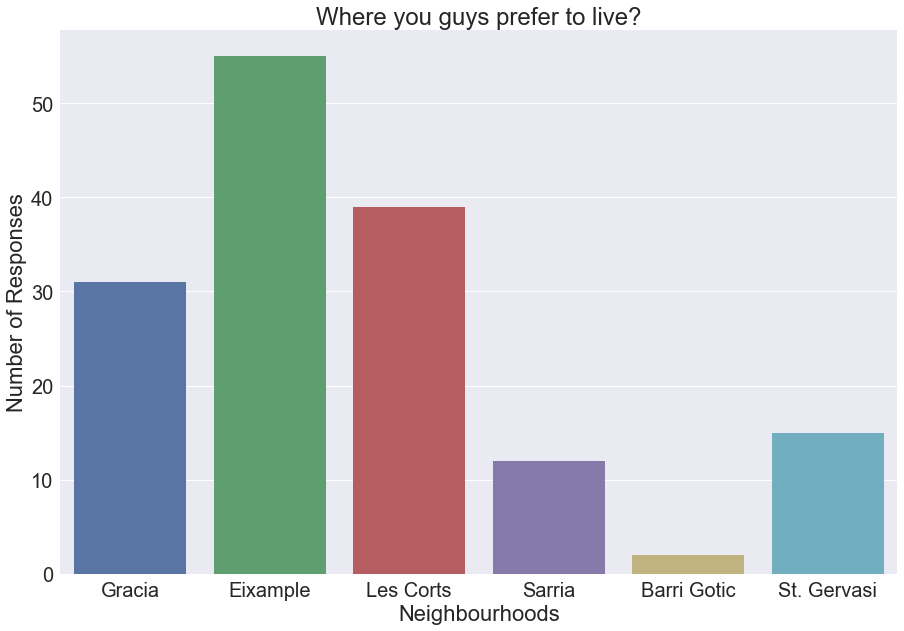

In [28]:
plt.figure(figsize=(15,10))
sns.set(font_scale=2)
plt.title('Where you guys prefer to live?')
sns.barplot(x=list(places.keys()), y=[i[2] for i in places.values()])
plt.xlabel("Neighbourhoods")
plt.ylabel("Number of Responses")
plt.savefig('places.jpg')

 ## Mapping of the neighhbourhoods
 

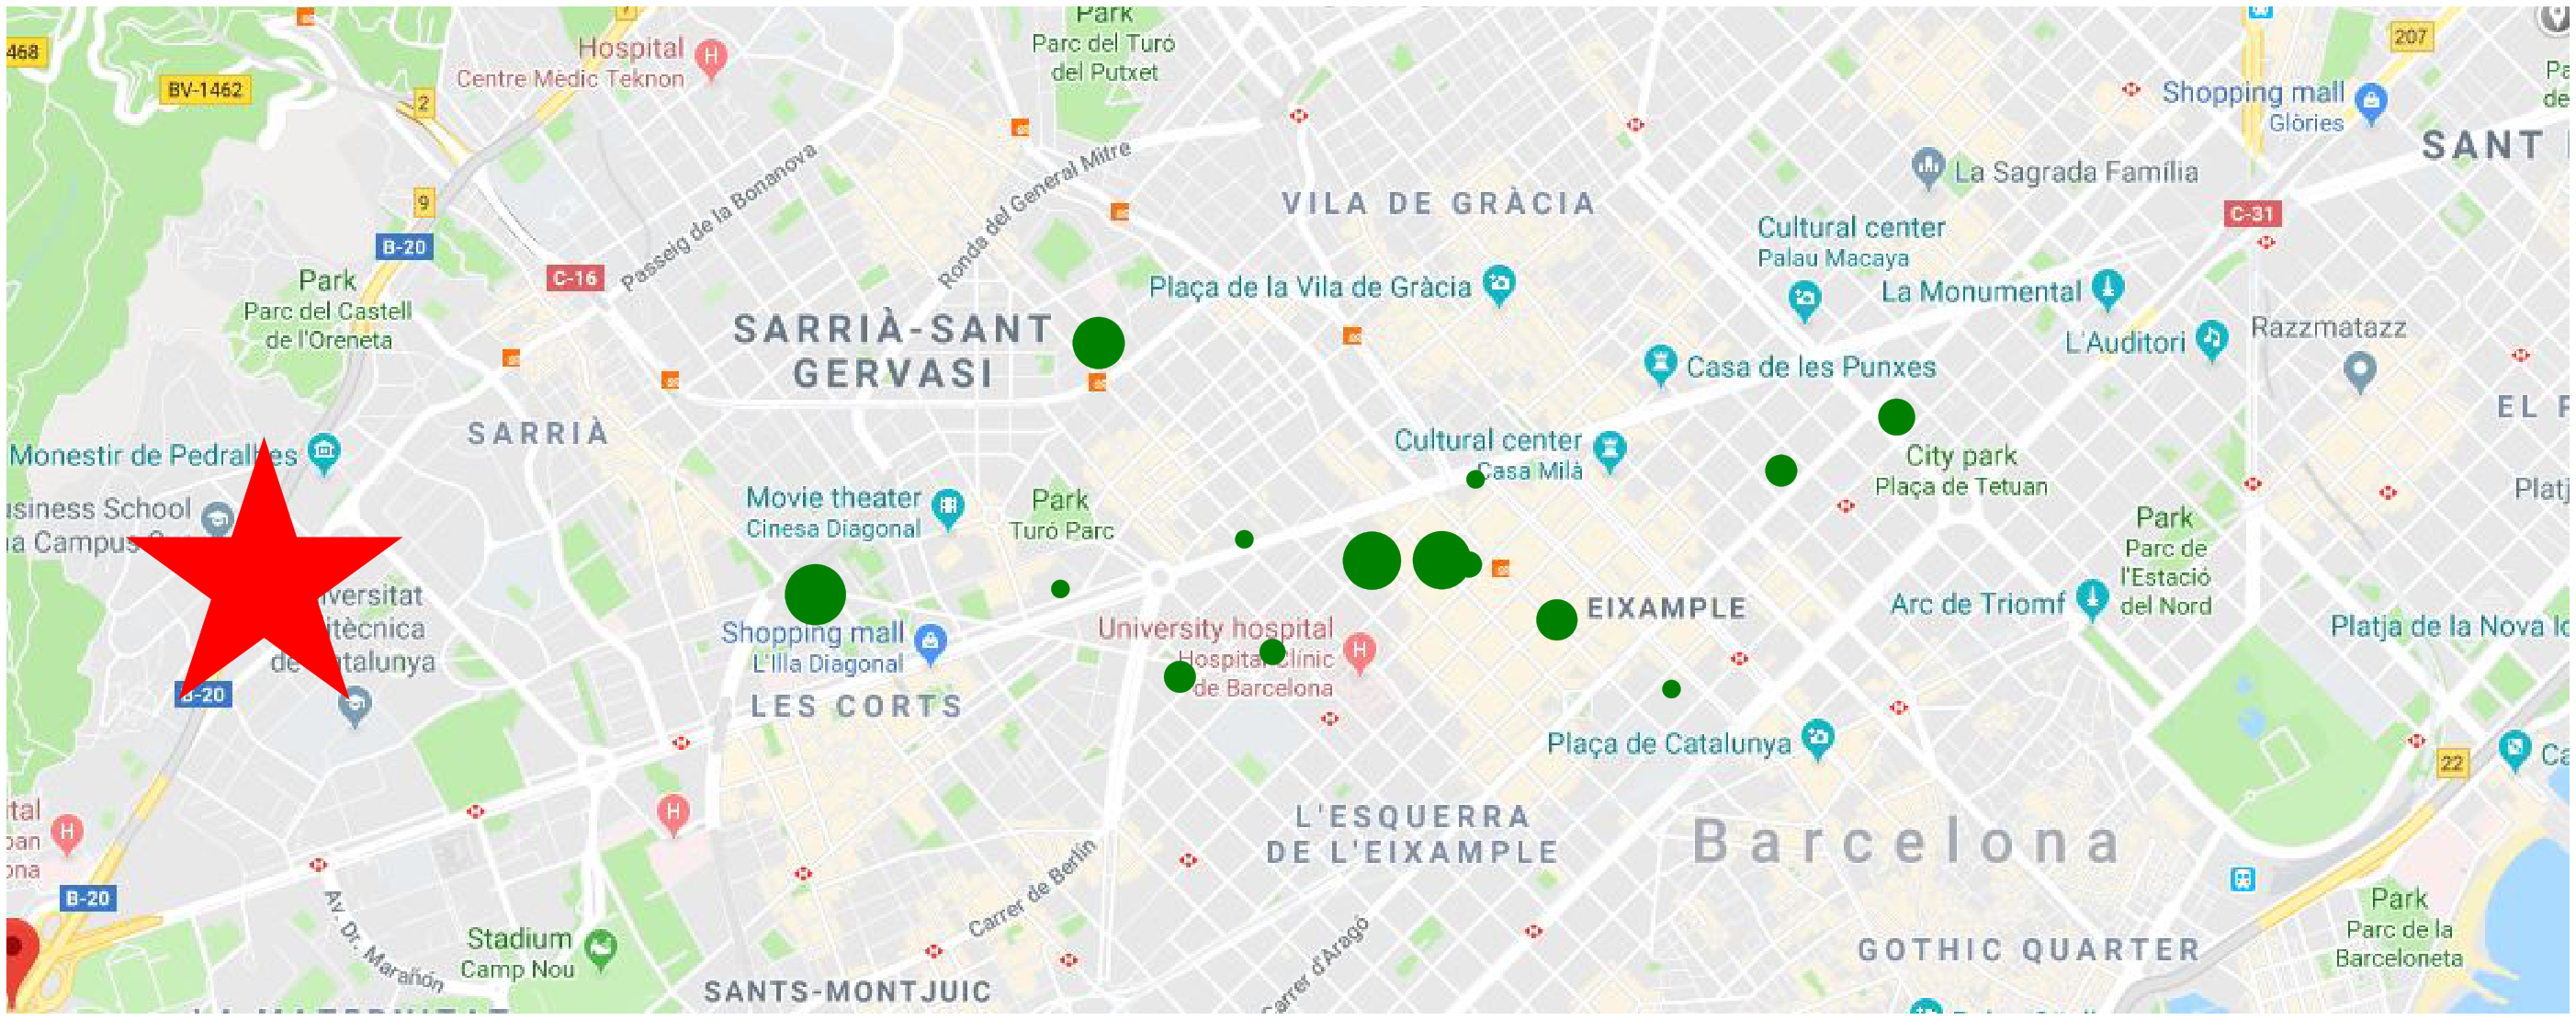

In [29]:
plt.figure(figsize=(50,25))
sns.set(font_scale=2)
img = plt.imread('mapa.JPG') #1158X455 image #41.38,2.1 to 41.41,2,2
#in the image, 0px starts from the top, smh
#need to invert all the x lines
img_x,img_y = 1158, 455
iese_x,iese_y = 41.383, 2.143 #fake location, I don't know why, but the original location doesnot work for me
locations_for_plot = [(location_X[i],location_Y[i]) for i in range(len(location_X))]
location_counter = Counter(locations_for_plot)
loc_X_plt = [i[0] for i in list(location_counter.keys())]
loc_X_plt = [(i-41.38)*img_x/(41.41-41.38) for i in loc_X_plt]
loc_Y_plt = [i[1] for i in list(location_counter.keys())]
loc_Y_plt = [(2.2-i)*img_y/(2.2-2.1) for i in loc_Y_plt]
location_size = [i*400 for i in list(location_counter.values())]
plt.scatter(loc_X_plt, loc_Y_plt,s=location_size,color='green')
plt.scatter([(iese_x-41.38)*img_x/(41.41-41.38)],[(2.2-iese_y)*img_y/(2.2-2.1)],s=[100000],marker = '*',color='red')
plt.imshow(img)
plt.grid(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.savefig('map_places.jpg')

In [13]:
my_answers.columns

Index(['Name', 'Interests', 'loc_X', 'loc_Y', 'price', 'furniture', 'sharing',
       'party', 'smoking', 'guest', 'gender_with'],
      dtype='object')

## What type of Pricing is preferred the most

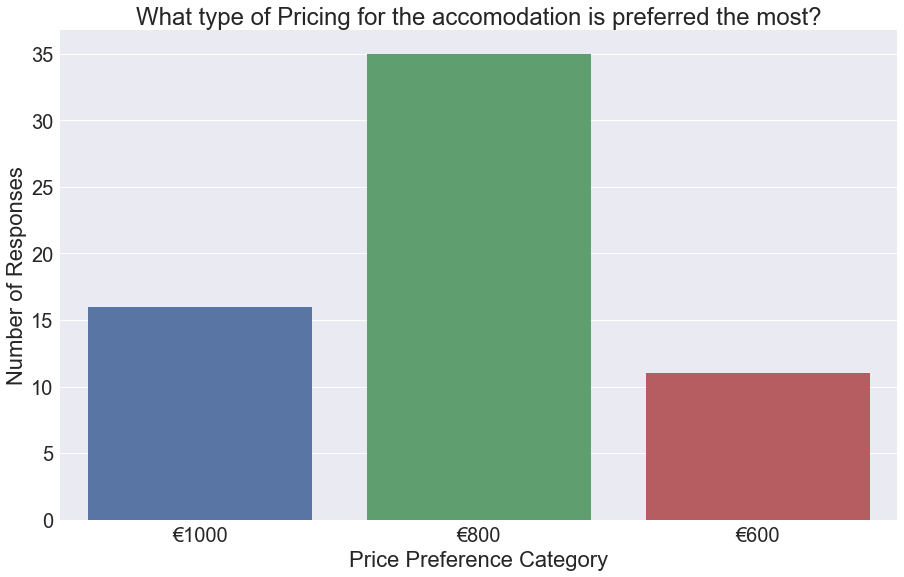

In [30]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('What type of Pricing for the accomodation is preferred the most?')
sns.barplot(x=['€1000','€800','€600'], y=[sum([1 for i in list(my_answers['price']) if (j[0]<i<j[1])]) for j in [(0,2.1),(2.2,3.1),(3.2,5)]])
plt.xlabel("Price Preference Category")
plt.ylabel("Number of Responses")
plt.savefig('pricing.jpg')

# What type of Furnishing is preferred the most

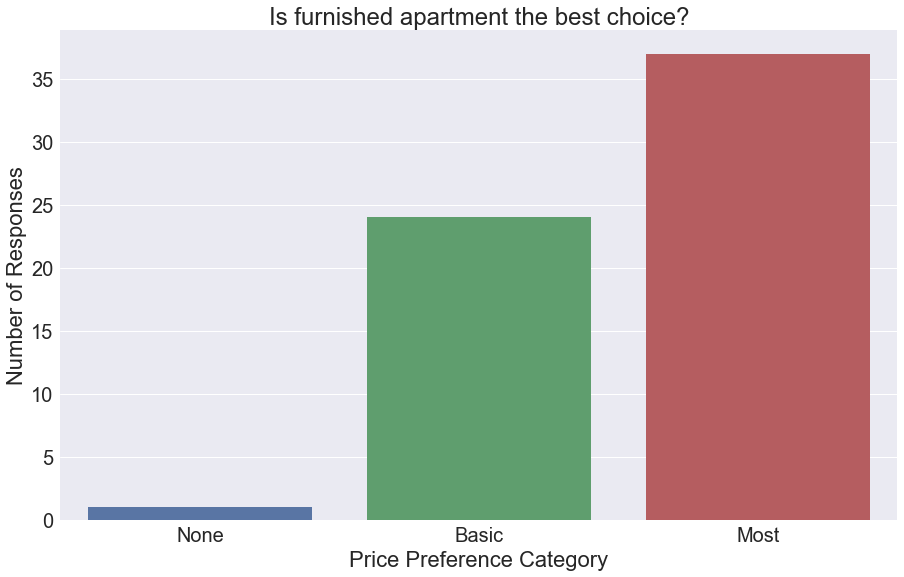

In [31]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('Is furnished apartment the best choice?')
sns.barplot(x=['None','Basic','Most'], y=[sum([1 for i in list(my_answers['furniture']) if (j==i)]) for j in [1,2,3]])
plt.xlabel("Price Preference Category")
plt.ylabel("Number of Responses")
plt.savefig('furniture.jpg')

# Sharing Prefrence

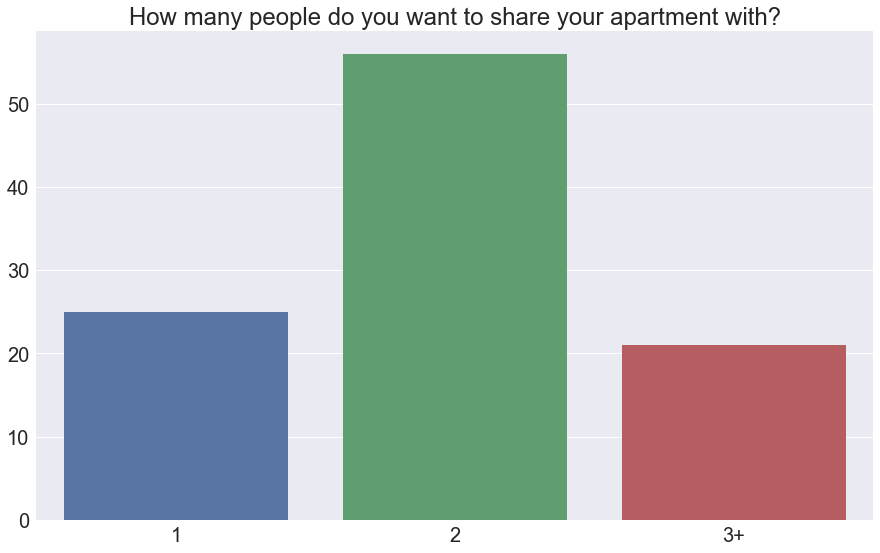

In [32]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('How many people do you want to share your apartment with?')
plt_y = [sum([1 for i in list(my_answers['sharing']) if (j[0]<i<j[1])]) for j in [(0,1.6),(1.4,2.6),(2.4,5)]]
sns.barplot(x=['1','2','3+'], y=plt_y)
plt.savefig('sharing.jpg')

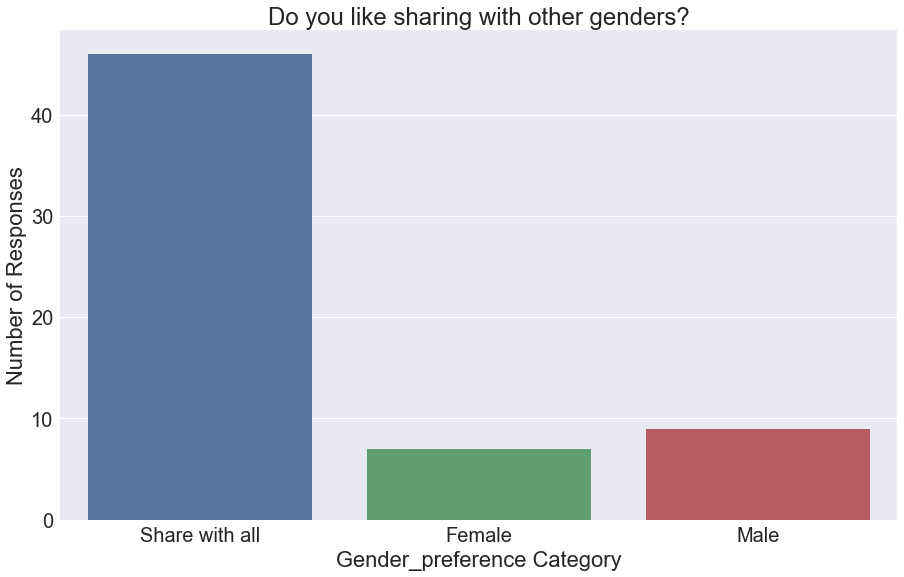

In [33]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('Do you like sharing with other genders?')
plt_y = [Counter(list(my_answers['gender_with']))[i] for i in [1,2,3]]
sns.barplot(x=['Share with all','Female','Male'], y=plt_y)
plt.xlabel("Gender_preference Category")
plt.ylabel("Number of Responses")
plt.savefig('room_sharing.jpg')

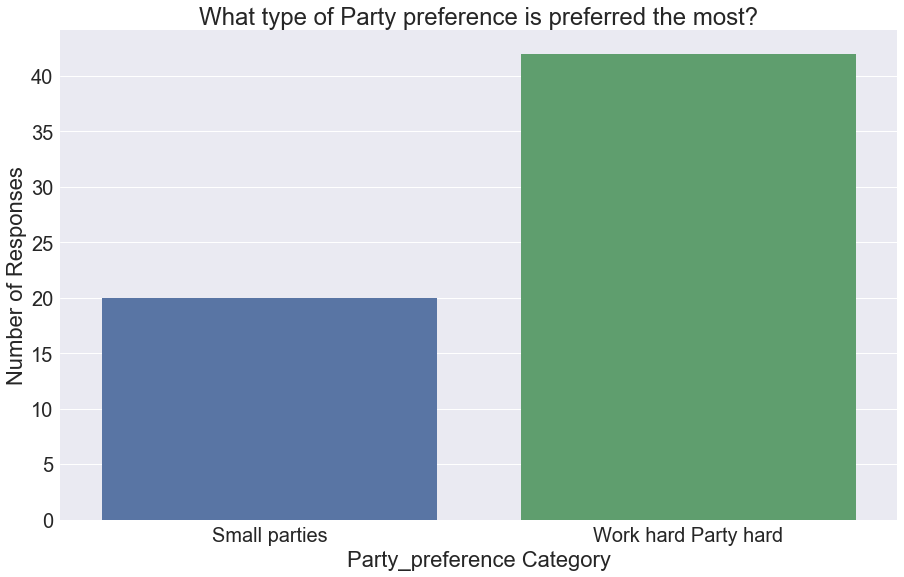

In [34]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('What type of Party preference is preferred the most?')
plt_y = [Counter(list(my_answers['party']))[i] for i in [2,3]]
sns.barplot(x=['Small parties','Work hard Party hard'], y=plt_y)
plt.xlabel("Party_preference Category")
plt.ylabel("Number of Responses")
plt.savefig('party.jpg')

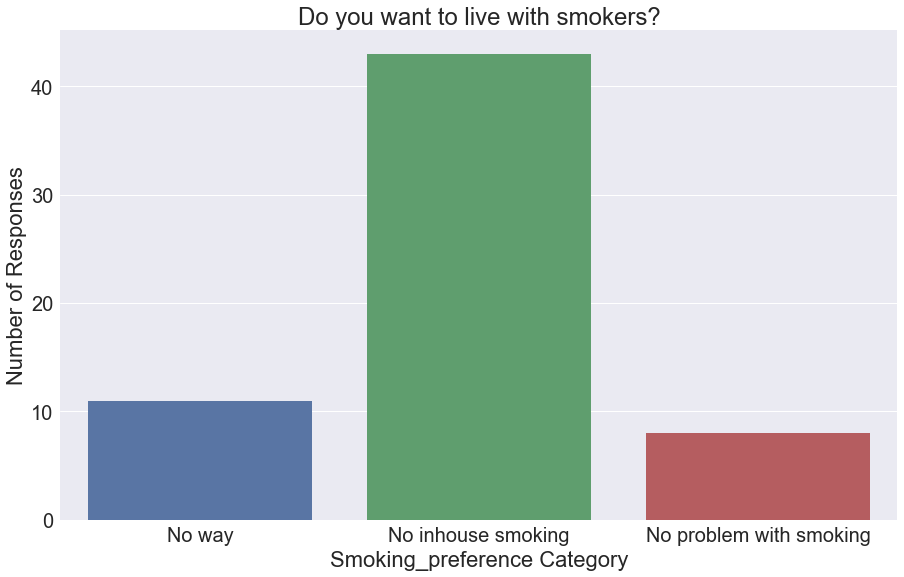

In [35]:
plt.figure(figsize=(15,9))
sns.set(font_scale=2)
plt.title('Do you want to live with smokers?')
plt_y = [Counter(list(my_answers['smoking']))[i] for i in [1,2,3]]
sns.barplot(x=['No way','No inhouse smoking','No problem with smoking'], y=plt_y)
plt.xlabel("Smoking_preference Category")
plt.ylabel("Number of Responses")
plt.savefig('smokers.jpg')

# Using Clustering Approach to segment user groups

- K Means clustering is used as the preferred choice for segmenting the clusters in an unsupervised way

In [22]:
cluster = KMeans(n_clusters=9)

In [23]:
# Adding 1 to initiate the clusters from 1 onwards instead of 0
my_answers['cluster'] = cluster.fit_predict(my_answers[my_answers.columns[2:]]) + 1 

In [24]:
print("Total segments created for the flatmates ",set(my_answers.cluster))

Total segments created for the flatmates  {1, 2, 3, 4, 5, 6, 7, 8, 9}


# Measuring the performance of the clusters

- Using RMSE to calculate the performance of the clusters.
- Lower the RMSE, the better is the performance of the cluster

Lower the RMSE, the better is the performance of the cluster


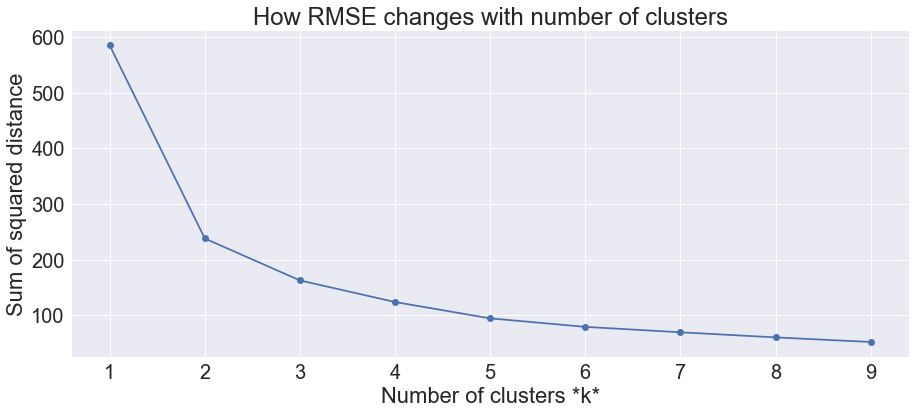

In [25]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(set(my_answers.cluster))

for k in list_k[0:]:
    km = KMeans(n_clusters=k)
    km.fit(my_answers[my_answers.columns[2:]])
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(15, 6))
plt.plot(list_k[0:], sse, '-o')
plt.title('How RMSE changes with number of clusters')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
print('Lower the RMSE, the better is the performance of the cluster')

## Displaying first 5 names in the segment

In [26]:
my_answers.sort_values(by=['cluster']).head()

Name  \
71      Alessandro Ciravegna   
25  Ana Paula De Avila Abreu   
54              Meghi Guerra   
7          Rahul Hotchandani   
50             Manuel Ferrer   

                                            Interests      loc_X     loc_Y  \
71  a. Watching Sports, b. Practicing Sports, d. S...  41.395968  2.145052   
25                     e. Playing music, f. Going out  41.395968  2.145052   
54                 b. Practicing Sports, f. Going out  41.396786  2.145100   
7   a. Watching Sports, b. Practicing Sports, c. C...  41.396786  2.145100   
50  a. Watching Sports, b. Practicing Sports, c. C...  41.396786  2.145100   

    price  furniture  sharing  party  smoking  guest  gender_with  cluster  
71    1.5        3.0      1.5    3.0      2.0    4.0            1        1  
25    3.5        3.0      2.0    3.0      1.0    4.0            1        1  
54    2.5        3.0      2.5    3.0      2.0    4.0            1        1  
7     3.0        3.0      1.5    3.0      3.0    4.0            1        1  
50    3.0        3.0      2.5    3.0      2.0    4.0            1        1

# Storing the results as csv

In [27]:
my_answers = my_answers.sort_values(by=['cluster'])

my_answers.to_csv("students_preference_matrix.csv")